In [14]:
import numpy as np
import pandas as pd
import scipy.stats as st
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import io
import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials
import os
from scipy.stats import bootstrap

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
#условие размера графиков
sns.set(rc={'figure.figsize':(12,4)}, style="whitegrid")

In [3]:
tables_name = ['project_2_active_studs', 'projec_2_checks', 'project_2_group_add', 'project_2_groups'] #названия датафреймов на моем диске

In [15]:
list_df = [] #создаем список чтобы туда добавлялись датафреймы

In [16]:

# Specify path to your file with credentials
path_to_credential = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-t-chernov-36/Data_fp/my-final-project-403511-32a5169a03fd.json' 

# Specify name of table in google sheets

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = ServiceAccountCredentials.from_json_keyfile_name(path_to_credential, scope)

gs = gspread.authorize(credentials)
def download_dataset(dataset): #создаем функцию для прочитывания датасетов из гугл таблиц и добавления датафрейма в список
    work_sheet = gs.open(dataset)

    # Select 1st sheet
    sheet1 = work_sheet.sheet1

    # Get data in python lists format
    data = sheet1.get_all_values()

    # Get header from data
    headers = data.pop(0)

    # Create df
    df = pd.DataFrame(data, columns=headers)
    
    #добавляем датафреймы в список
    list_df.append(df)
    
    return

In [17]:
download_dataset('project_2_active_studs') #вызываем функцию, добавляя active_studs в список

In [18]:
active_studs = list_df[-1] #присваиваем имя датафрейму из последнего добавленного

In [19]:
download_dataset('projec_2_checks') 

In [20]:
checks = list_df[-1]

In [21]:
download_dataset('project_2_group_add')

In [22]:
groups_add = list_df[-1]

In [23]:
download_dataset('project_2_groups')

In [24]:
groups = list_df[-1]

In [25]:
active_studs

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


In [15]:
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [16]:
groups_add

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [17]:
groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


Нулевая гипотеза (H0): Разницы между средней суммой в тестовой и контрольной группе нет
Альтернативная гипотеза (H1): Разница между средней суммой  в тестовой и контрольной группе есть

In [18]:
#проверка на пропущенные значения
for i, df in enumerate(list_df):
    if df.isna().values.any():
        print(f"Датафрейм {i+1} содержит пропущенные значения.")
    else:
        print(f"Датафрейм {i+1} не содержит пропущенных значений.")

Датафрейм 1 не содержит пропущенных значений.
Датафрейм 2 не содержит пропущенных значений.
Датафрейм 3 не содержит пропущенных значений.
Датафрейм 4 не содержит пропущенных значений.


In [19]:
#проверка на дублкаты 
for i, df in enumerate(list_df):
    if df.duplicated().values.any():
        print(f"Датафрейм {i+1} содержит дубликаты.")
    else:
        print(f"Датафрейм {i+1} не содержит дубликатов.")

Датафрейм 1 не содержит дубликатов.
Датафрейм 2 не содержит дубликатов.
Датафрейм 3 не содержит дубликатов.
Датафрейм 4 не содержит дубликатов.


In [20]:
#Объединяем группы в одну
groups_all = pd.concat([groups, groups_add], axis=0)


In [21]:
#Исправляем название колонки для идентичности с другими датафреймами
active_studs.rename(columns={'student_id': 'id'}, inplace=True)

In [22]:
#Объединяем датафреймы active_studs с groups_all левым джоином , таким образом мы получим список активных студенов,
                                                                                    #оплативших услугу по группам
activ_group = pd.merge(active_studs, groups_all, how='left', on='id')


In [23]:
activ_group

,id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B
...,...,...
8336,1794344,B
8337,296883,B
8338,3598448,B
8339,3610547,B


In [24]:
#проверка дубликатов
activ_group.duplicated().sum()

0

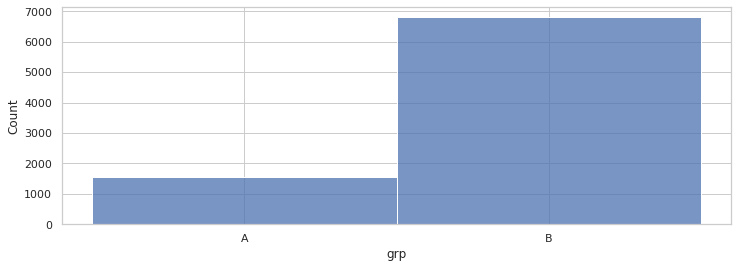

In [23]:
#провекра количества пользователей по группам
sns.histplot(data=activ_group, x="grp")

In [25]:
#Исправляем название колонки для идентичности с другими датасетами
checks.rename(columns={'student_id': 'id'}, inplace=True)

In [26]:
#Объединяем датасеты activ_group с checks через left join, таким образом мы узнаем количество активных пользователей, оплативших услугу по 
#группам, с учетом тех кто ничего не купил, то есть 0
checks_group = pd.merge(activ_group, checks, how='left', on='id')


In [27]:
checks_group = checks_group.fillna(0) #превращаем пропущенные значения в нули 

In [28]:
checks_group

,id,grp,rev
0,581585,A,0
1,5723133,A,0
2,3276743,B,0
3,4238589,A,0
4,4475369,B,0
...,...,...,...
8336,1794344,B,0
8337,296883,B,0
8338,3598448,B,0
8339,3610547,B,290.0


In [30]:
checks_group.dtypes #смотрим типы данных 

id     object
grp    object
rev    object
dtype: object

In [31]:
checks_group['rev'] = checks_group['rev'].astype(float)  #меняем на флоат 

In [32]:
#Находим CR и выдим что в контрольной группе CR выше чем в тестовой
(checks_group.query('rev > 0').groupby('grp', as_index = False).agg({'rev': 'count'}).rev/\
checks_group.groupby('grp', as_index = False).agg({'rev': 'count'}).rev)*100

0    5.071521
1    4.615611
Name: rev, dtype: float64

In [33]:
arppu_df = checks_group.query('rev > 0').groupby('grp', as_index = False).agg({'rev': 'mean'})

In [34]:
arppu_df.rename(columns={'rev': 'arppu'}, inplace=True)

In [35]:
#в тестовой группе ARPPU больше чем в контрольной
arppu_df

,grp,arppu
0,A,933.589744
1,B,1257.878992


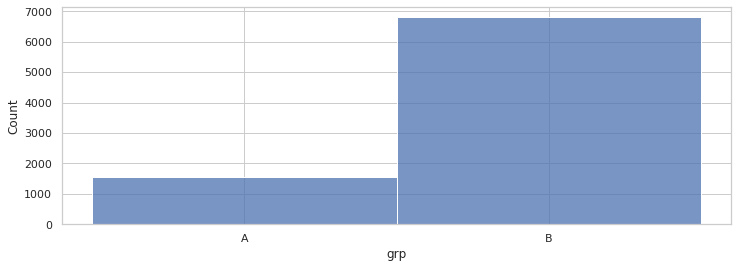

In [39]:
sns.histplot(data=checks_group, x="grp")
#размеры групп сильно различаются, необходимо быть особенно осторожным и обращать внимание на возможные искажения в результатах теста

In [36]:
checks_group.groupby('grp').rev.describe()
#стандартное отклонение слишком велико
#среднее значение в тестовой группе выше чем среднее значение в контрольной группе

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,1538.0,47.347204,290.490632,0.0,0.0,0.0,0.0,3660.0
B,6803.0,58.058798,313.770201,0.0,0.0,0.0,0.0,4650.0


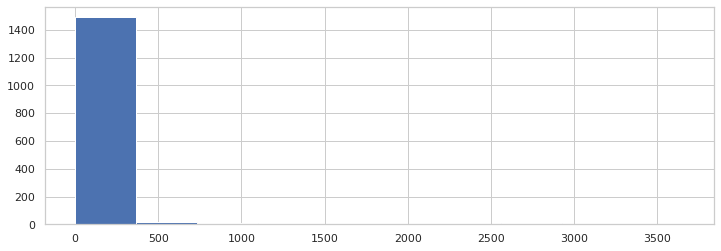

In [73]:
#График распределения контр группы
checks_group.query("grp == 'A'").rev.hist()

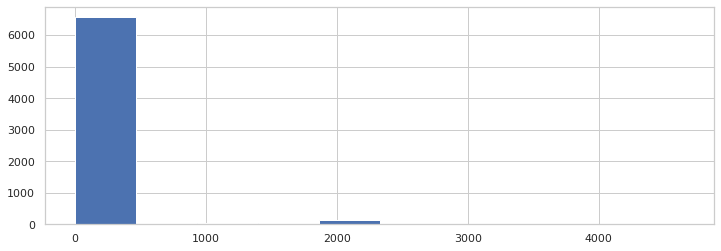

In [74]:
#График распределения тестовой группы
checks_group.query("grp == 'B'").rev.hist()

In [37]:
#прологарифмируем значения так как десперсия высокая и нули логарифировать не будем
checks_group['rev_log'] = checks_group['rev'].apply(lambda x: np.log(x) if x > 0 else 0)

In [38]:
# находим стандартное отклонение
checks_group.groupby('grp').rev_log.std()

grp
A    1.429917
B    1.449334
Name: rev_log, dtype: float64

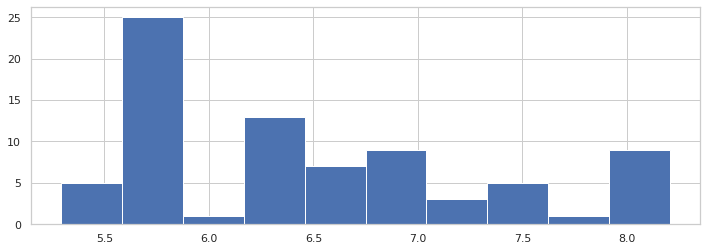

In [81]:
#График распределения прологарифмированной контр группы 
checks_group.query("grp == 'A' and rev_log > 0").rev_log.hist()

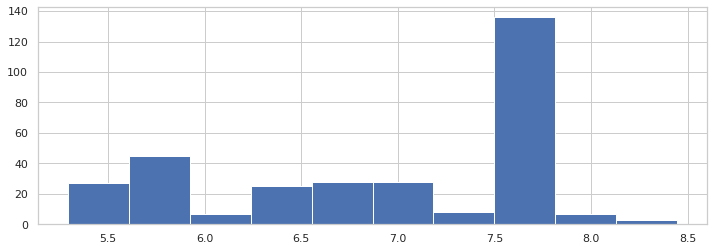

In [84]:
#График распределения прологарифмированной тестовой группы
checks_group.query("grp == 'B' and rev_log > 0").rev_log.hist()

In [39]:
# проверка на нормальность
pg.normality(data=checks_group, dv="rev_log", group="grp", method="normaltest")
#Вывод: распределение во всех выборках ненормальное

,W,pval,normal
A,1313.800565,5.150296e-286,False
B,5938.301984,0.000000e+00,False


In [40]:
control_df = checks_group[checks_group.grp == 'A'] #создаем датафрейм контрольной группы

In [41]:
control_df = control_df[['rev','grp']] #создаем датафрейм контрольной группы

In [55]:
control_df

,rev,grp
0,0.0,A
1,0.0,A
3,0.0,A
7,0.0,A
21,0.0,A
...,...,...
8317,0.0,A
8320,0.0,A
8326,0.0,A
8330,0.0,A


In [42]:
test_df = checks_group[checks_group.grp == 'B'] #создаем датафрейм тестовой группы

In [43]:
test_df = test_df[['rev','grp']] #создаем датафрейм тестовой группы

In [66]:
test_df

,rev,grp
2,0.0,B
4,0.0,B
5,0.0,B
6,0.0,B
8,0.0,B
...,...,...
8336,0.0,B
8337,0.0,B
8338,0.0,B
8339,290.0,B


In [44]:
bootstrap((control_df.rev, ), np.mean) # Используем статистический метод bootsrap и находим доверительный интервал статистических
#показателей контроольной группы

BootstrapResult(confidence_interval=ConfidenceInterval(low=35.18395997829643, high=64.99929108059739), standard_error=7.399783556354723)

In [45]:
bootstrap((test_df.rev, ), np.mean) # Используем статистический метод bootsrap и находим доверительный интервал статистических
#показателей тестовой группы

BootstrapResult(confidence_interval=ConfidenceInterval(low=50.86528740536172, high=66.03852102062012), standard_error=3.816951955983682)

Нулевая гипотеза (H0): Разницы между средней суммой в тестовой и контрольной группе нет

Альтернативная гипотеза (H1): Разница между средней суммой  в тестовой и контрольной группе есть

**Вывод:**
1)Я смотрю на среднюю сумму оплаты (checks.rev)  Потому что чем больше выручка, тем успешнее новая механика оплаты. 

2)Cреднее значение в тестовой группе выше чем среднее значение в контрольной группе, CR в контрольной группе выше, а ARPPU ниже 
чем в тестовой

Так как метрика является колличественной переменной и у нас есть 2 группы которые планируем сравнивать по одному критерию, 
и распределение у нас ненормальное, то  для сравнения используем BOOTSTRAP

Доверительные интервалы параметров двух групп перекрываются, поэтому мы принимаем нулевую гипотезу,
что разница между средней суммой  в тестовой и контрольной группе нет.
Поэтому доказанно, что запускать новую механику оплаты на всех пользователей **НЕ стоит!**